# Homework 4 
## Predicting the Poverty of Costa Ricans

<img src="samara-costa-rica-e1466922358715.jpg">

Costa Rica is a country rich in culture and history. Although its name literally translated means "Rich Coast," for many people, poverty is a large concern. So without asking every single person what their net worth is, how can we determine their poverty status, and how can we make our model as efficient as possible by using few variables while still maintaining a high accuracy? We will use different sets of variables as well as various models, testing for their F1 Score to achieve a balanced result between recall and accuracy. 

That is the basis of this kernel, and we hope to be able to answer that question by the end of this project.

***

_Many thanks to the people and kernels I consulted. I could not have completed this project without them._

- https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough
- https://www.kaggle.com/youhanlee/3250feats-532-feats-using-shap-lb-0-436
- https://www.analyticsindiamag.com/7-types-classification-algorithms/

***

### Import Modules
To start we have to import the basic modules in order to begin the process of importing data.

In [2]:
#import our basic data manipulation modules
import pandas as pd
import numpy as np
import scipy

#import our basic visualization modules
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#turn off warnings for sns depreciated versions- this is the best
import warnings
warnings.filterwarnings('ignore')

#import modules that describe distributions
from scipy import stats
from scipy.stats import kurtosis
from scipy.stats import skew

### Import Data
From there, we can begin to import our data and look to see what we have to work with. We also want to ensure that we are saving the ID and the target columns so that we don't lose them through any of our processes.

In [3]:
#Import data, calling it df
df = pd.read_csv(r"Data\train.csv")
#Immediate save ID and Target in new variables
hogar = df['idhogar']
ID = df['Id']
Target = df['Target']
#Look at what we're working with
df.head(5)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


Wow. Thats a lot of variables. What are all of these? Well if we look back at the page from which we got the data, we will see that they have prepared descriptions of each variable that they have provided us. Let's take a look: __[Costa Rican Poverty Data Set](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data)__

According to the explanation provided, there are four core variables:
- `Id` - This is the unique identifier for each Individual. However, we are hoping to predict level of poverty on the household level, so we won't be using this one for long.
 
- `Target` - This is the target is an ordinal variable indicating groups of income levels.
 - 1 = Households in Extreme Poverty 
 - 2 = Households in Moderate Poverty 
 - 3 = Financially Vulnerable Households
 - 4 = Households **Not** Financially Vulnerable


- `idhogar` - This is the unique identifier for each household. It will be used to create household-wide features. All rows in a given household will have a matching value for this identifier.

- `parentesco1` - This variable indicates if this person is the head of the household.

From there, we are provided another 142 variables ranging from the education of household members to the grade of walls on the home. We will not describe them all in detail here, but we will work to decrease the necessary data collected to predict the poverty level, as stated above. However, to do so, we next need to clean our data. 


## Cleaning Data

The next step is actually cleaning the data. We will be doing that in several steps. First we will check to make sure that each of the variable data types are correctly determined. If not, we will fix them. Then we will check for nulls in our data which can negatively affect certain models, like linear models. We will then check for any outliers, even though some models are fairly resistent to them. Once that is complete, we will check for high correlation between variables and remove any variables that could negatively affect our model predictions. Lets get started!

### Correct Data Types
So to start off, we are going to look at the distribution of variables in each of the different data types.



In [4]:
#show types of columns in df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


We see that there are 8 variables that are float64, which means they are continuous. We have another 130 that are int64, which are just integers or distinct numbers. That means that they could be ordinal, cardinal or boolean type variables. Lastly, there are 5 variables that are object type variables, which are basically categorical.  

The only category we really need to be worried with is the object category. If there were alphanumeric characters in the float or integer columns, they would have been converted to object. In the case of the boolean type columns that are integers, we don't need to be concerned. So, lets look at what the variables involved with the object columns are:

In [5]:
#show top 5 of object columns
df.select_dtypes('object').head(5)

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


It makes sense that `Id` and `idhogar` are objects, and at first glance the other should be as well seeing as they have no's and possibly yes's. However, before we get too excited, lets check the variable descriptions to see what they should be:

> `edjefe` - years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, **yes=1 and no=0**

> `edjefa` -  years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, **yes=1 and no=0**

> `dependency` -  Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)

It looks like for `edjefe` and `edjefa`, "yes" just 1 and "no" just means 0. I think that this is likely the case for dependency as well, so lets fix the data accordingly and then convert the three columns to float.

In [6]:
#set up variable to fix the yes's and no's
correct_yn = {"no": 0, "yes": 1}

# Fill in the values with the correct mapping and set as float
df['dependency'] = df['dependency'].replace(correct_yn).astype(np.float64)
df['edjefa'] = df['edjefa'].replace(correct_yn).astype(np.float64)
df['edjefe'] = df['edjefe'].replace(correct_yn).astype(np.float64)

#Check the results
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(11), int64(130), object(2)
memory usage: 10.4+ MB


Okay that looks great now. I feel confident that each of our variables are correctly classified. Now, our next step is work on...
### Removing Nulls
This step is essential for our models to function properly. The process is as follows:

1. Determine where the nulls are
2. Determining whether they should be filled in or just dropped
3. Determine the process of determining which values should fill the nulls
3. Finish by filling all null values

So lets see how many nulls we have and where they are!

In [7]:
#define function to show nulls
def show_them_nulls(dataset):
    #create NA's count variable
    nas = df.isnull().sum().sort_values(ascending=False)
    #create percent variable
    percent = 100*(df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    #combine lists and display all non-zeros
    nasnum_train = pd.concat([nas, percent],axis=1,keys=['NAs','Percent'])
    headlength = np.count_nonzero(nas)
    print(nasnum_train.head(headlength))

#Run it
show_them_nulls(df)

            NAs    Percent
rez_esc    7928  82.954902
v18q1      7342  76.823271
v2a1       6860  71.779847
meaneduc      5   0.052318
SQBmeaned     5   0.052318


It looks like we have 5 variables that have Null values. What are these variables?

> `rez_esc`, Years behind in school

> `v18q1`, number of tablets household owns

> `v2a1`, Monthly rent payment

> `meaneduc`,average years of education for adults (18+)

> `SQBmeaned`, square of the mean years of education of adults (>=18) in the household
agesq, Age squared

For right now, we are going to drop anything that has 80%+ of the data null. That makes it so that we aren't predicting too much data which could introduce major false data into our df.

In [8]:
#dropping rez_esc
df = df.drop(['rez_esc'],axis=1)

What about `v18q1` (how many tablets are the in the home)? Well lets look at the distribution of the results and see if we can see any pattern.

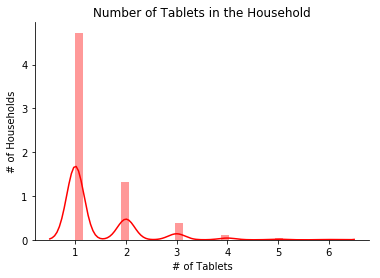

In [9]:
#create variable for number of tablets without na's
test_v18q1 = df['v18q1'].dropna()
#create plot of distributions
fig, ax = plt.subplots()
sns.distplot(test_v18q1,color='red')
#set title & axes
plt.title('Number of Tablets in the Household')
ax.set_xlabel('# of Tablets')
ax.set_ylabel('# of Households')
#make pretty
sns.despine()
plt.show()

Wait! Where are the households with zero tablets? Do you expect me to believe that every household in Costra Rica has at least one tablet? Well a quick look about the variable descriptions produces the following variable:

>`v18q`, owns a tablet

So lets test to make sure that every time `v18q1` is null, `v18q` is 0 (a household doesn't have a tablet).

In [10]:
#create pivot table to 
print(df.pivot_table(values='v18q1',columns='v18q'))
print(df.pivot_table(values='v18q1',columns='v18q',dropna=True))

v18q          1
v18q1  1.404063
v18q          1
v18q1  1.404063


This result means that in every case that the `v18q` is 0, `v18q1` is null but should be zero. So we'll replace all nulls with 0's. Also, since we have all the information from `v18q` in `v18q1`, we can drop `v18q`.

In [11]:
#v18q1 is the number of tablets, fill in with zeros
df['v18q1'] = df['v18q1'].fillna(0)
#drop v18q
df = df.drop(['v18q'],axis=1)

Let's see how we're doing so far:

In [12]:
show_them_nulls(df)

            NAs    Percent
v2a1       6860  71.779847
SQBmeaned     5   0.052318
meaneduc      5   0.052318


Okay, only three left
Our next step that we'll take is to clean up `meaneduc` and `SQBmeaned`. We are going to take the `edjefe` to fill in the `meaneduc` and then square it to get our `SQBmeaned`.

In [13]:
#give them the median education for their age for mean educ
df['meaneduc'] = df.apply(
    lambda row: row['edjefe'] if np.isnan(row['meaneduc']) else row['meaneduc'],
    axis=1
)
#Square our meaneduc for any nulls in 
df['SQBmeaned'] = df.apply(
    lambda row: row['meaneduc']**2 if np.isnan(row['SQBmeaned']) else row['SQBmeaned'],
    axis=1
)

Now we have just one last variable with nulls that we need to take care of. What exactly is `v2a1`?

> `v2a1`, Monthly rent payment

We see that there are 70% of people not responding. Although this is likely not incorrect, it does mean that it is a less helpful measure, seeing as we have a renting variable already, `tipovivi3`, so we are just going to drop the column as a whole.

In [14]:
#drop v2al
df = df.drop('v2a1',axis=1)

We officially have no more nulls! Lets celebrate with a ridiculous meme that will introduce our next process in cleaning our data:

<img src="C-658VsXoAo3ovC.jpg" width="400">

### Checking for High Correlation
When using certain models, it is extremely important that variables are not too highly correlated in order for them to work properly. So we are going to create matrices of our variables and then remove any that have too high of a correlation and keep the alternates that has a greater correlation with the target variable. To start lets create a couple of functions that will allow us to do this more quickly once we get started!

In [15]:
#Create a list that displays only numeric variables
numeric_var=df.select_dtypes(include=[np.number]).columns
#Here we set up our correlation matrix for numeric variables
correlation=df[numeric_var].corr()
#Pull the max (whether positive or negative) correlation of each variable to another variable
aux=(abs(correlation)-np.identity(correlation.shape[0])).max()
#Print the max correlation for Target
aux[[-1]]

Target    0.334759
dtype: float64

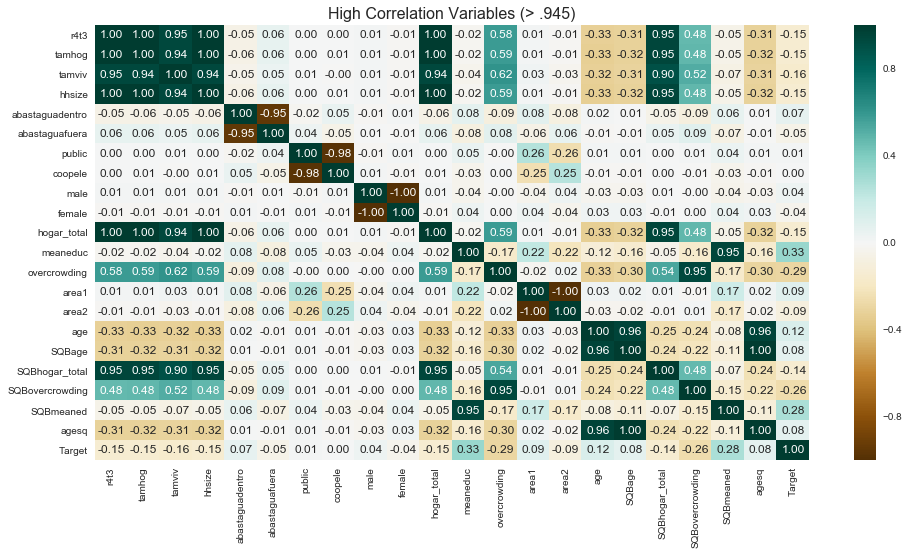

In [16]:
#Throw out any variables that don't have at least .7 correlation with something else or isn't Target
selected_feats=aux[(aux>0.945) | ((aux>.334758) & (aux<.334760))].index
sns.set()
fig, ax = plt.subplots(figsize=(16,8))
#make the plot have numbers, a legend and pretty colors
sns.heatmap(correlation.loc[selected_feats,selected_feats], annot=True,fmt='.2f',ax=ax,cmap="BrBG",center=0)
plt.title('High Correlation Variables (> .945)',fontsize=16)
#show the plot
plt.show()

So the darker the color is on our grid, the higher correlation there is between the variables on the X and Y. The following are the sets of variables from which all but one may need to be removed:

**Highly Correlated Variables:**
 - `r4t3` & `tamhog` & `hhsize` & `hogar_total`: It looks like these are all measuring the exact same thing, so lets keep `hhsize` and remove the other three.
 - `public` and `coopele`: `public` has a higher correlation so we can drop `coopele`
 - `area1` & `area2`: As `area1` and `area2` are a dichotomy, we can drop `area2`
 - `male` & `female`: Same issue as above, so we can drop `female`
 - `abastaguadentro` & `abastaguafuera`: Are boolean variables showing whether there is a water provision on the inside or outside of the dwelling. As there is a third option of no water in a different variable, we will leave these for now.

In [17]:
#dropping the aforementioned columns
df = df.drop(['r4t3','tamhog','hogar_total','coopele','area2','female'],axis=1)

Now, looking forward, I see that there are nine squared variables, which are just other variables that we have, but squared. Although in the case of linear model this is helpful, they are just extra variables that we do not need.

**Squared Variables:**
>`SQBescolari`, escolari squared

>`SQBage`, age squared

>`SQBhogar_total`, hogar_total squared

>`SQBedjefe`, edjefe squared

>`SQBhogar_nin`, hogar_nin squared

>`SQBovercrowding`, overcrowding squared

>`SQBdependency`, dependency squared

>`SQBmeaned`, square of the mean years of education of adults (>=18) in the household

> `agesq`, Age squared

So we're going to drop these variables. 

In [18]:
#drop all squared variables
df = df.drop(['SQBescolari','SQBage','SQBhogar_total','SQBedjefe','SQBhogar_nin','SQBovercrowding','SQBdependency','SQBmeaned', 'agesq'],axis=1)

Our next step is feature engineering, however before we start that process, lets see how we've been able to cut down on the number of variables:

In [19]:
#how many rows and columns do we have?
df.shape

(9557, 125)

Well that's something! We originally had 143 variables and we're down to 125. Let's try making some variables that might be even more effective than the ones with which we were provided!

### Feature Engineering
I think some of the most powerful new variables I can create are the "per person in the household." While there aren't too many variables that have been counted discretely, but for those that have been we will create variables for each of them. (Except for the number of adults or children as this is measured by the `dependency` variable.

In [20]:
#create new variables for each of the discrete variables divided by the number of people living in the house
df['phones_inhome'] = df['qmobilephone'] / df['tamviv']
df['tablets_inhome'] = df['v18q1'] / df['tamviv']
df['rooms_inhome'] = df['rooms'] / df['tamviv']

Now, lets create variables for each of the same ones, except instead of those just inside the home, we'll look at the each item but divide it for each person in the entire family, even if they're not living at home. The reason I'm doing this is that even though the people may not be living at home, they likely are either using resources from their base-household or are contributing to it. We'll find out!

In [21]:
#create new variables for each of the discrete variables divided by the number of people in the entire household
df['phones_permember'] = df['qmobilephone'] / df['hhsize']
df['tablets_permember'] = df['v18q1'] / df['hhsize']
df['rooms_permember'] = df['rooms'] / df['hhsize']

Now by that same logic, we should create a variable that is a percentage of the family members in the home.

In [22]:
#Create variable for percentage of family members in home
df['percent_inhome'] = df['tamviv'] / df['hhsize']

Lastly, it was brought to my attention that I should also create a special measure for if a house is especially dangerous or especially luxuarious. So the following are what I have modified from that idea. For `peligroso` or dangerous, I'm counting the problematic measures (if there is no bathroom, electric, floor, water or roof). Then for luxaries, I'm counting if the home has a refrigerator, a computer, the number of tablets and if they have a tv. We'll see what difference this makes.

In [23]:
# create the dangerous variable
df['peligroso'] = (df['sanitario1'] + df['noelec'] + df['pisonotiene'] + df['abastaguano'] - df['cielorazo'])
#create the luxurious variable 
df['luxaries'] =df['refrig'] + df['computer'] + df['v18q1'] + df['television']

Okay! Now that our data is set up and all ready to go, we can jump on into the fun stuff! Fitting and testing our models! While we could go ahead and just fit the models immediately, I find its best to set up all of the functions we're going to use to test the models first, that way we can make sure that we keep it very clean and legible where the actual results are. Lets get going!
### Setting up our Testing Equipment & Finish Pre-Processing

To start off, we're going to need to import our scalers, our crossvalidations, our models, and our scoring modules.

In [24]:
#Import our scaler
from sklearn.preprocessing import StandardScaler

#Bring in our crossvalidations
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, KFold

#Import the models we will be using
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

#Import the modules we will use to score our models
from sklearn.metrics import confusion_matrix, f1_score, make_scorer, accuracy_score, mean_squared_error
import itertools

First off, we need to make sure that we can measure how good our models are, so we need to create a new type of scorer called, `F1_scorer`

In [25]:
F1_scorer = make_scorer(f1_score, greater_is_better=True, average='weighted')

Next, after fitting each model, we want to see how good it was at predicting the results of our test set. Since we'll be doing this four times, let's set up a new variable to take care of this for us each time:

In [26]:
#Create a variable that will show us the best parameters, with what accuracy it predicts and what the F1 score is for its predictions
def show_me_the_money(model,test_y,test_x):
    print("Best Params: {}".format(model.best_params_))
    print("Test Accuracy: {}".format(accuracy_score(test_y, model.predict(test_x))))
    print("F1 Score: {}".format(f1_score(test_y, model.predict(test_x),average='macro')))

Another aspect that we want to check for is the confusion plot, or how it predicted the family's poverty status vs the actual poverty status. So we're going to borrow a confusion plot and modify it for our benefit. We'll then feed that defined function into an even shorter one that is more specific to our needs

In [27]:
#generalized confusion matrix plot
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize = (8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 20)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 16)
    plt.xlabel('Predicted label', size = 16)

    
#specific matrix for our needs    
def show_con_matrix(model,test_y,test_x,title):
    pred_matrix = confusion_matrix(test_y, model.predict(test_x))
    plot_confusion_matrix(pred_matrix, classes = ['Extreme', 'Moderate', 'Vulnerable', 'Non-Vulnerable'],
                      title = title)
    plt.show

As those are our main three measures, we are good to finally finish pre-processing our data. We're going to set up our two separate dataframes from our currect one, 'df', then we are going to feed them through the standard scaler to ensure that there aren't any oversized coefficients. Lastly, we will use a train_test_split in order to have two sets of data and test how good our models really are!

In [28]:
#Retain our id fields
Id = df['Id']
IdHogar = df['idhogar']
#Create the two new data frames
train_y = pd.DataFrame()
train_x = pd.DataFrame()
#save our Target as our y variable
train_y['Target'] = df['Target']
train_x = df.drop(['Target','Id','idhogar'],axis=1)

In [29]:
#set up the scaler
scaler = StandardScaler()
#fit and transform x
scaler.fit(train_x)
scaled_df = scaler.transform(train_x)
#fit and transform y
scaler.fit(train_y)
scaled_df = scaler.transform(train_y)

In [30]:
#perform the train & test split
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.3001, random_state=13)

**Show time.**
### Testing the Models
I have selected four models (one being an ensemble), and will try each with the dataset that we have prepared. Then we will see which has the best results:

#### 1.) Gaussian Naive Bayes
This is the first model that we will be testing. It doesn't have any hyperparameters to speak of so we won't be using a CV gridsearch. Also, seeing as it will likely be the least effective, we won't bother with cross validation either.

In [31]:
#set up model
gnb = GaussianNB()

#fit model
gnb.fit(X_train,y_train)
#because there aren't hyperparameters, we can't use our fancy defined function, so we'll pull the results manually
print("Test Accuracy: {}".format(accuracy_score(y_test, gnb.predict(X_test))))
print("F1 Score: {}".format(f1_score(y_test, gnb.predict(X_test),average='macro')))

Test Accuracy: 0.3053328685953294
F1 Score: 0.2585906355940008


Ouch. Not great. Well let's move on to our next model.
#### 2.) Stochiastic Gradient Descent Classifier
Next we will use the stochiastic gradient descent classifier and try a number of different hyperparameters to see which are the most effective at getting a high F1.

In [32]:
#set up model, allow it to use all cores
sgd = SGDClassifier(n_jobs=-1)

#set hyperparameters
param_grid = {"loss": ['hinge', 'log', 'modified_huber',
    'squared_hinge', 'perceptron'],
             "l1_ratio" :[.001, .04, .5, .69, .8, .9, .99, .999],
             "penalty":['none', 'l2', 'l1', 'elasticnet']}

#set up the grid search, with 5 crossvalidations and scoring based on our F1_scorer that we created
sgd_gridsearch = GridSearchCV(sgd,param_grid=param_grid,scoring=F1_scorer,cv=5)

#fit model
sgd_gridsearch.fit(X_train,y_train)

#see how it did
show_me_the_money(sgd_gridsearch,y_test,X_test)

Best Params: {'l1_ratio': 0.99, 'loss': 'log', 'penalty': 'none'}
Test Accuracy: 0.6260020913210178
F1 Score: 0.41488303647889146


That's a bit better. Our accuracy doubled, however our F1 did not. Not the best. Moving on...
#### 3.) K-Nearest Neighbors
This one I figured would do the best out of the normal models as it has quite a few ways to optimize the hyperparameters. Lets see how it does.

In [33]:
#set up model, allow it to use all cores
knk = KNeighborsClassifier(n_jobs = -1)

#set hyperparameters
param_grid = {"n_neighbors": [2,3,4, 5, 7],
             "weights": ['uniform','distance'],
              "p": [1,2,3]}

#set up the grid search, with 5 crossvalidations and scoring based on our F1_scorer that we created
knk_gridsearch = GridSearchCV(knk,param_grid=param_grid,scoring=F1_scorer,cv=5)

#fit model
knk_gridsearch.fit(X_train,y_train)

#see how it did
show_me_the_money(knk_gridsearch,y_test,X_test)

Best Params: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Test Accuracy: 0.7807598466364587
F1 Score: 0.6835495791205836


Not bad. But I also wouldn't submit this to the government unless I wanted people to die from starvation. It looks like it is better than guessing in terms of accuracy, but the F1 is still quite poor. 
#### 4.) Random Forest Classifier
This is the special ensemble model. I assume this is going to do the best and I'll add more hyperparameters to ensure that. Then after this we'll take the time to compare the results.

In [34]:
#set up model, allow it to use all cores
rfc = RandomForestClassifier(random_state=42, n_jobs = -1)

#set hyperparameters
param_grid = {"n_estimators": [ 105, 110, 115, 120],
             "max_features": ['auto','log2'],
             "criterion":['gini','entropy'],
             "min_samples_leaf":[1,2,3,4],
             "bootstrap":[True, False]}


#set up the grid search, with 5 crossvalidations and scoring based on our F1_scorer that we created
rfc_gridsearch = GridSearchCV(rfc,param_grid=param_grid,scoring=F1_scorer,cv=5)

#fit model
rfc_gridsearch.fit(X_train,y_train)

#see how it did
show_me_the_money(rfc_gridsearch,y_test,X_test)

Best Params: {'bootstrap': False, 'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 110}
Test Accuracy: 0.9414430115022656
F1 Score: 0.9127317697258518


That is significantly better than any other model. Let's compare the models and see how .
### Checking Our Models for Efficacy
Although I'm pretty sure that the Random Forrest Classifier is the best, lets check to be more conclusive.

In [35]:
#Print the Naive Gaussian Bayes Results
print("1.) Naive Gaussian Bayes")
print("Test Accuracy: {}".format(accuracy_score(y_test, gnb.predict(X_test))))
print("F1 Score: {}".format(f1_score(y_test, gnb.predict(X_test),average='macro')))
print("**********************************************************************************")
#Print the Stochiastic Gradient Descent Results
print("2.) Stochiastic Gradient Descent")
show_me_the_money(sgd_gridsearch,y_test,X_test)
print("**********************************************************************************")
#Print the K Nearest Neighbors Results
print("4.) K Nearest Neighbors")
show_me_the_money(knk_gridsearch,y_test,X_test)
print("**********************************************************************************")
#Print the Random Forrest Classifier Results
print("5.) Random Forrest Classifier")
show_me_the_money(rfc_gridsearch,y_test,X_test)

1.) Naive Gaussian Bayes
Test Accuracy: 0.3053328685953294
F1 Score: 0.2585906355940008
**********************************************************************************
2.) Stochiastic Gradient Descent
Best Params: {'l1_ratio': 0.99, 'loss': 'log', 'penalty': 'none'}
Test Accuracy: 0.6260020913210178
F1 Score: 0.41488303647889146
**********************************************************************************
4.) K Nearest Neighbors
Best Params: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Test Accuracy: 0.7807598466364587
F1 Score: 0.6835495791205836
**********************************************************************************
5.) Random Forrest Classifier
Best Params: {'bootstrap': False, 'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 110}
Test Accuracy: 0.9414430115022656
F1 Score: 0.9127317697258518


Okay, its clear that the Random Forrest Classifier is by far the best. Lets see how the model is predicting the test data.

Confusion matrix, without normalization


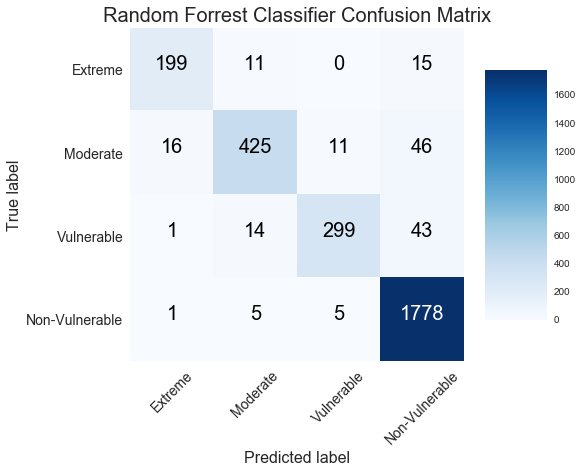

In [36]:
#Show confusion matrix
show_con_matrix(rfc_gridsearch,y_test, X_test,'Random Forrest Classifier Confusion Matrix')

It looks pretty good. The only square that I am fairly concerned about is the 31 that are in Extreme Poverty but are predicted as being Non-Vulnerable. However, for now, lets just look at what the most important features are and finish with that.

In [37]:
#Specify and fet random forrest classifier so we can pull the feature importances
final_rfc = RandomForestClassifier(criterion= 'entropy', max_features= 'auto', min_samples_leaf= 1, n_estimators= 110)
final_rfc.fit(X_train,y_train)
#Retrieve feature importances and insert them into a dataframe
imp_feat = sorted(list(zip(train_x.columns, final_rfc.feature_importances_)), key=lambda x: x[1], reverse=True)

Text(0.5,1,'Feature Importances')

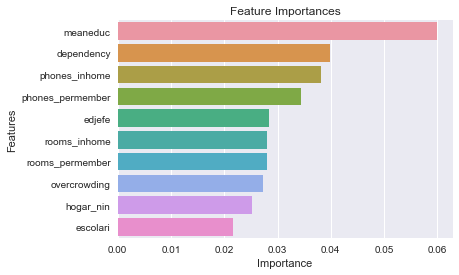

In [38]:
#Create a plot of the top ten importances
importance = pd.DataFrame(imp_feat,columns=['Features','Importance'])
sns.barplot('Importance','Features',data=importance.head(10))
plt.title('Feature Importances')

It looks like the most important features are the education (by quite a bit), the dependency ratio, and for some reason, the home. If we can create a census based on these top ten features, we should be fairly effective at predicting the poverty level. 

**Fin.**